In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.save_account('78a4e395a27e3cce2d6bea6321d4b618bacc9db3c5f4506850b2616b7444da36b01e2c0d1f27119c77dbbde833366731ea64401e8fab2f852fa84a4c4317a11b', overwrite=True)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
nqubits = 4
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/requests_ntlm/requests_ntlm.py:5: CryptographyDeprecationWarning: Python 3.5 support will be dropped in the next release of cryptography. Please upgrade your Python.
  from cryptography import x509
/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/qiskit/__init__.py:91: DeprecationWarning: Using Qiskit with Python 3.5 is deprecated as of the 0.12.0 release. Support for running Qiskit with Python 3.5 will be removed at the Python 3.5 EoL on 09/13/2020.
  "Python 3.5 EoL on 09/13/2020.", DeprecationWarning)
/home/oryosu/anaconda3/envs/qiskit/lib/python3.5/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_ourense


In [14]:
driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
repulsion_energy = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
qubitOp = ferOp.mapping(map_type='parity')
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)

In [15]:
qubitOp.num_qubits

2

In [2]:
from qiskit import Aer, execute
backend = BasicAer.get_backend("statevector_simulator")

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(backend)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

Interatomic Distance: 0.5 VQE Result: -1.055159794447963 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.1162860068311218 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.1361894540111401 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.1341476666204406 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.1205601297760261 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.101150318806139 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.0791929449548827 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -1.0567407449308335 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -1.0351862637975315 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -1.0154682470624605 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.9981493525246022 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.983472728864899

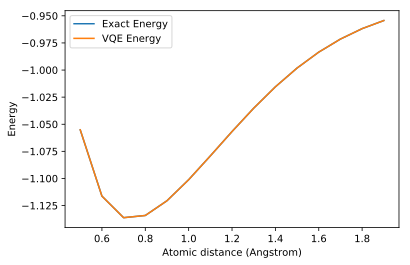

<Figure size 432x288 with 0 Axes>

In [3]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()
plt.savefig("H2_statevector.png")

In [4]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_ourense")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

Interatomic Distance: 0.5 VQE Result: -0.9967325045481237 Exact Energy: [-1.05515979]
Interatomic Distance: 0.6 VQE Result: -1.0606407862132545 Exact Energy: [-1.11628601]
Interatomic Distance: 0.7 VQE Result: -1.0790508045713407 Exact Energy: [-1.13618945]
Interatomic Distance: 0.8 VQE Result: -1.0818598823230783 Exact Energy: [-1.13414767]
Interatomic Distance: 0.9 VQE Result: -1.0740836365124258 Exact Energy: [-1.12056028]
Interatomic Distance: 1.0 VQE Result: -1.0455912444780349 Exact Energy: [-1.10115033]
Interatomic Distance: 1.1 VQE Result: -1.0232183995965003 Exact Energy: [-1.07919294]
Interatomic Distance: 1.2 VQE Result: -0.9815204762495329 Exact Energy: [-1.05674075]
Interatomic Distance: 1.3 VQE Result: -0.9554841455533911 Exact Energy: [-1.03518627]
Interatomic Distance: 1.4 VQE Result: -0.9322029916623633 Exact Energy: [-1.01546825]
Interatomic Distance: 1.5 VQE Result: -0.8983637367210936 Exact Energy: [-0.99814935]
Interatomic Distance: 1.6 VQE Result: -0.8630099574179

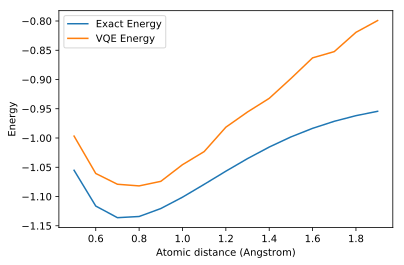

<Figure size 432x288 with 0 Axes>

In [5]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()
plt.savefig("H2_qc.png")